# Westworld character network

## Quality issues
* The wiki contains pages on the 70s movies and 80s TV series, not just HBO's. Collect those IDs and exclude them from the dataset (_carefully_, in case any names are re-used)
* Categories (like "Antagonists") are included in the API request for character pages. Drop any that have "Category" in their url

In [1]:
import pandas as pd
import requests
import json
from xml.etree import ElementTree

import networkx as nx
import matplotlib.pyplot as plt

## Get node names and ids
The wiki IDs will be used to access the individual article for that node

In [2]:
chars_request = requests.get('https://westworld.fandom.com/api/v1/Articles/List?expand=1&category=Characters&limit=200').json()['items']
chars = [dict(id=x['id'], name=x['title'], url=x['url']) for x in chars_request]

In [3]:
loc_request = requests.get('https://westworld.fandom.com/api/v1/Articles/List?expand=1&category=Locations&limit=200').json()['items']
locs = [dict(id=x['id'], name=x['title'], url=x['url']) for x in loc_request]

In [4]:
tech_request = requests.get('https://westworld.fandom.com/api/v1/Articles/List?expand=1&category=Technology&limit=200').json()['items']
tech = [dict(id=x['id'], name=x['title'], url=x['url']) for x in tech_request]

In [5]:
park_request = requests.get('https://westworld.fandom.com/api/v1/Articles/List?expand=1&category=Park management&limit=200').json()['items']
parks = [dict(id=x['id'], name=x['title'], url=x['url']) for x in park_request]

## Collect structured relationships from articles
Most people's articles have a 'Relationships' section, where sub-headings are other charactes

In [6]:
# Test the relationships scraper on single person
arnold = [x for x in chars if x['id'] == 2764][0]
page_sections = requests.get(f"https://westworld.fandom.com/api/v1/Articles/AsSimpleJson?id={arnold['id']}").json()['sections']

# Get Relationships sections
rel_section = [x for x in page_sections if x['title'] == 'Relationships'][0]
rel_section_start = page_sections.index(rel_section) + 1
rel_next_section = [x for x in page_sections[rel_section_start:] if x['level'] == 2][0]
rel_section_end = page_sections.index(rel_next_section)

links = [sec['title'] for sec in page_sections[rel_section_start:rel_section_end]]
links

['Dolores Abernathy', 'Robert Ford']

In [7]:
def get_links(char_dict):
    page_sections = requests.get(f"https://westworld.fandom.com/api/v1/Articles/AsSimpleJson?id={char_dict['id']}").json()['sections']

    # Get Relationships sections
    try:
        rel_section = [x for x in page_sections if x['title'] == 'Relationships'][0]
        rel_section_start = page_sections.index(rel_section) + 1
        rel_next_section = [x for x in page_sections[rel_section_start:] if x['level'] == 2][0]
        rel_section_end = page_sections.index(rel_next_section)
    except IndexError:  # no relationships, forever alone
        return None

    links = [sec['title'] for sec in page_sections[rel_section_start:rel_section_end]]
    if links:
        return links
    else:  # sometimes the Relationships section exists, but it's empty
        return None
    

In [8]:
for character in chars:
    character['links'] = get_links(character)

In [9]:
chars[6]

{'id': 2764,
 'name': 'Arnold Weber',
 'url': '/wiki/Arnold_Weber',
 'links': ['Dolores Abernathy', 'Robert Ford']}

## Labeling hosts and humans

In [10]:
# Add label to character dictionaries

def add_species_label(char_dict):
    """Add is_host and is_human keys to character dictionary."""
    # Get names from wiki category
    hosts_request = requests.get('https://westworld.fandom.com/api/v1/Articles/List?expand=1&category=Hosts&limit=200').json()['items']
    humans_request = requests.get('https://westworld.fandom.com/api/v1/Articles/List?expand=1&category=Human&limit=200').json()['items']
    hosts = [x['id'] for x in hosts_request]
    humans = [x['id'] for x in humans_request]
    
    for char in char_dict:
        char['is_host'] = char['id'] in hosts
        char['is_human'] = char['id'] in humans

add_species_label(chars)

In [13]:
df = pd.DataFrame.from_dict(chars).set_index('id')
df.loc[~df.is_host & ~df.is_human]

,name,url,links,is_host,is_human
id,,,,,
11482,Ash,/wiki/Ash,None,False,False
11639,Benny,/wiki/Benny,None,False,False
11097,Caleb Nichols,/wiki/Caleb_Nichols,None,False,False
3190,Eye Patch,/wiki/Eye_Patch,None,False,False
11133,Francis,/wiki/Francis,None,False,False
11104,George,/wiki/George,None,False,False
7008,Grace,/wiki/Grace,None,False,False
11055,Irene Gerhart,/wiki/Irene_Gerhart,None,False,False
8563,Ivan,/wiki/Ivan,None,False,False


## Scraping for additional details

In [162]:
# Request XML of full wiki page
# Using Arnold as an example

def construct_xml_url(char_dict):
    """Get the URL for the XML export of a wiki page."""
    base_url = 'https://westworld.fandom.com'
    url_str = char_dict['url'].split('/')
    url_str.insert(2, 'Special:Export')
    url_str = '/'.join(url_str)
    url_str = base_url + url_str
    return url_str

char_url = construct_xml_url(arnold)
response = requests.get(char_url)
tree = ElementTree.fromstring(response.content)
print(tree)

<Element '{http://www.mediawiki.org/xml/export-0.10/}mediawiki' at 0xa2741ea10>


## Network graph

In [32]:
G = nx.Graph()
char_nodes = [x['name'] for x in chars]
char_nodes_lite = [x['name'] for x in chars if x['links']]
G.add_nodes_from(char_nodes_lite)

In [33]:
# Edges
# must be a list of tuples of 2 character names [('Ford', 'Arnold'), ('Arnold', 'Bernard')]

def link_gen(char_dict_list):
    """A generator which creates link tuples."""
    for character in char_dict_list:
        if not character['links']:
            continue
        for link in character['links']:
            yield (character['name'], link)
            
char_links = [x for x in link_gen(chars)]
G.add_edges_from(char_links)

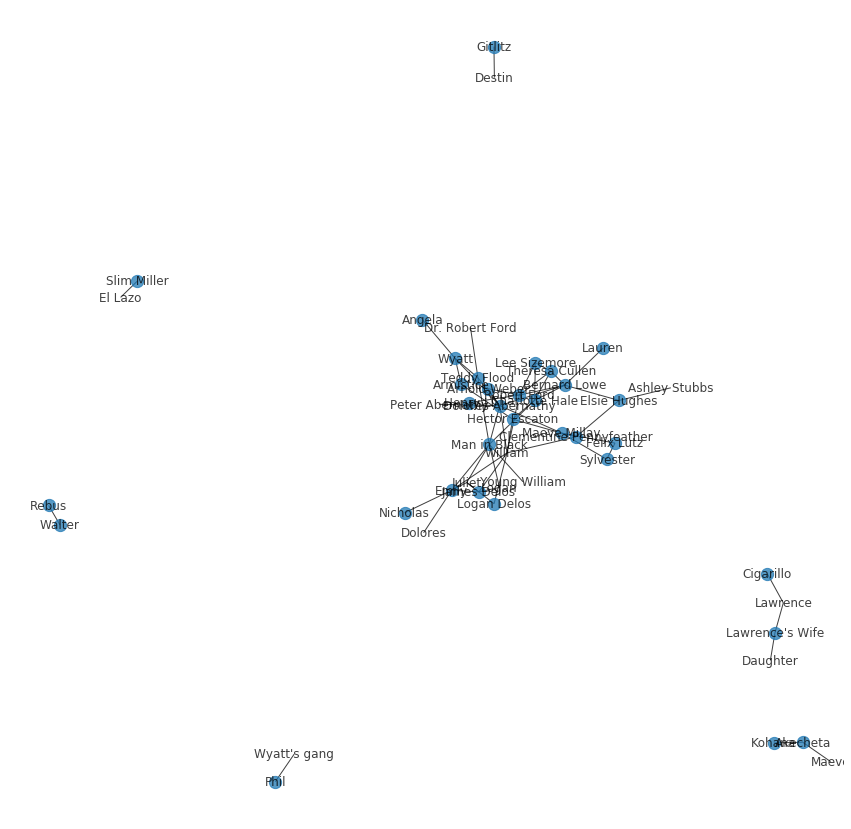

In [35]:
# Draw the graph
plt.figure(figsize=(15, 15))
plt.subplot(111)
nx.draw(
    G, 
    with_labels=True,
    nodelist=[x['name'] for x in chars if x['links']],  # only ones with relationships
    node_size=150,
    alpha=0.75,
    label='Westworld Characters'
)